In [2]:
#import all the required libraries
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import keras
#import keras's Reuters Neswire Classification Dataset
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Then we set some parameters that will be used throughout the notebook. The batch size is the number of samples processed before the model is updated. The number of epochs is the number of complete passes (iteration) through the training dataset

In [3]:
max_words = 10000  # Parameter indicating the number of words we'll put in the dictionary to create word vector
batch_size = 64  # Size of the batches used in the mini-batch gradient descent
epochs = 5  # Number of epochs we usually start to train with

Loading Reuters data from Keras

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)

In [5]:
print('length of x_train sequences',len(x_train))
print('length of x_test sequences',len(x_test))

length of x_train sequences 8982
length of x_test sequences 2246


In [6]:
num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

46 classes


# DATA PREPARATION

Vectorizing sequence data

In [7]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 10000)
x_test shape: (2246, 10000)


Converting class vector to binary class matrix

In [8]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


# DATA MODELLING

Building Dense FNN Model

In [9]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(max_words,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(num_classes, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [10]:
def deep_model(model):
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(x_train
                       , y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_split=0.3
                       , verbose=1)
    
    return history

base_history = deep_model(base_model)

Train on 6287 samples, validate on 2695 samples
Epoch 1/5
6287/6287 [==============================] - 3s 530us/step - loss: 1.9380 - accuracy: 0.5922 - val_loss: 1.2050 - val_accuracy: 0.7280
Epoch 2/5
6287/6287 [==============================] - 3s 419us/step - loss: 0.8957 - accuracy: 0.7994 - val_loss: 0.9788 - val_accuracy: 0.7859
Epoch 3/5
6287/6287 [==============================] - 3s 417us/step - loss: 0.4943 - accuracy: 0.8918 - val_loss: 0.9036 - val_accuracy: 0.7959
Epoch 4/5
6287/6287 [==============================] - 3s 419us/step - loss: 0.3037 - accuracy: 0.9383 - val_loss: 0.8940 - val_accuracy: 0.8108
Epoch 5/5
6287/6287 [==============================] - 3s 416us/step - loss: 0.2009 - accuracy: 0.9564 - val_loss: 0.9346 - val_accuracy: 0.8000


As the no of epochs (iterations), the train loss decreases and remains almost stagnant for the validation set.  The same thing occurs for the accuracy, which increases for the training set but remain stagnant for the validation set. This is a symptom of over-fitting.

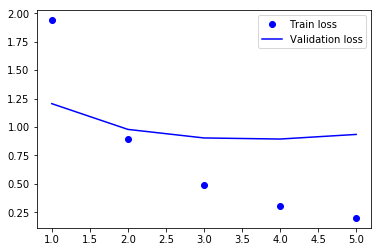

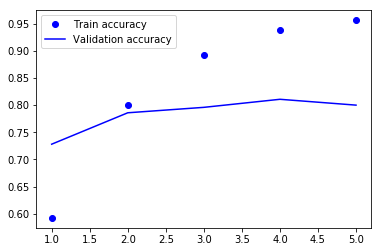

In [11]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, epochs + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
eval_metric(base_history, 'loss')
eval_metric(base_history, 'accuracy')

Now, we remove one hidden layer and also decrease the no of neurons from 64 to 32. This will hopefully reduce over-fitting

In [32]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(max_words,)))
reduced_model.add(layers.Dense(num_classes, activation='softmax'))
reduced_model.summary()

reduced_history = deep_model(reduced_model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_19 (Dense)             (None, 46)                1518      
Total params: 321,550
Trainable params: 321,550
Non-trainable params: 0
_________________________________________________________________
Train on 6287 samples, validate on 2695 samples
Epoch 1/5
6287/6287 [==============================] - 4s 559us/step - loss: 2.3158 - accuracy: 0.5717 - val_loss: 1.4419 - val_accuracy: 0.7043
Epoch 2/5
6287/6287 [==============================] - 2s 319us/step - loss: 1.1203 - accuracy: 0.7655 - val_loss: 1.1016 - val_accuracy: 0.7655
Epoch 3/5
6287/6287 [==============================] - 2s 276us/step - loss: 0.7496 - accuracy: 0.8459 - val_loss: 0.9672 - val_accuracy: 0.7933
Epoch 4/5
6287/6287 [======

### Less over-fitting with reduced model
Here we can see that the baseline model sees increasing losses while the reduced model (with fewer neurons and one hidden layer less) loss does not increase even with increasing epochs.

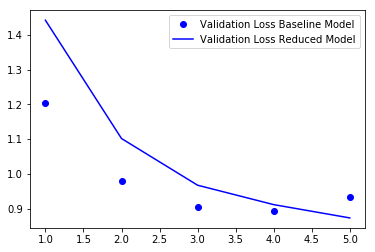

In [33]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, epochs + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()
    
compare_loss_with_baseline(reduced_history, 'Reduced Model')

### Reducing over-fitting by dropping
Another way to reduce over-fitting is by randomly dropping data-sets for training. In this case, an additional hidden layer is used to drop some of the intermediate training data. As observed below, the validation loss for dropout model is slightly lesser than the baseline model.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 46)                2990      
Total params: 5,156,334
Trainable params: 5,156,334
Non-trainable params: 0
_________________________________________________________________
Train on 6287 samples, validate on 2695 samples
Epoch 1/5
6287/6287 [==============================] - 11s 2ms

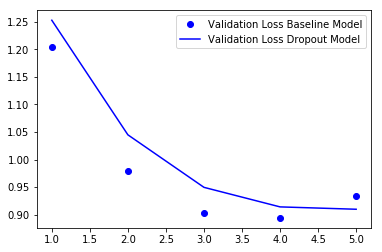

In [16]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(512, activation='relu', input_shape=(max_words,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(num_classes, activation='softmax'))
drop_model.summary()

drop_history = deep_model(drop_model)

def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, epochs + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()


compare_loss_with_baseline(drop_history, 'Dropout Model')

In [22]:
score = base_model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 1s 320us/step
Test loss: 1.001180202113871
Test accuracy: 0.7978628873825073


In [23]:
score = drop_model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 1s 276us/step
Test loss: 1.0922101104461182
Test accuracy: 0.8107746839523315


In [34]:
score = reduced_model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 1s 317us/step
Test loss: 0.9066880392582418
Test accuracy: 0.7943009734153748


### Validate the model with live data from RSS feeds

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AishwaryaBose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# Import RSS feeds 

import feedparser

#r_feeds = feedparser.parse('http://feeds.bbci.co.uk/news/world/rss.xml')
#r_feeds = feedparser.parse('http://feeds.reuters.com/Reuters/worldNews')
#r_feeds = feedparser.parse('http://feeds.feedburner.com/CommodityBlog')
#r_feeds = feedparser.parse('http://www.tradingfloor.com/commodities/rss/extract')
#r_feeds = feedparser.parse('https://news.google.com/rss?x=1571747689.2745&hl=en-IN&gl=IN&ceid=IN:en')
r_feeds = feedparser.parse('https://oilprice.com/rss/main')

In [26]:
news_titiles = []

for feed in r_feeds['entries']:
    news_titiles.append((feed['title'])) 

In [27]:
from nltk import word_tokenize
from keras.preprocessing import sequence

WordIndex = reuters.get_word_index(path="reuters_word_index.json")

IndexToWord = {}
for key, value in WordIndex.items():
    IndexToWord[value] = keymax_review_length = 2000

As drop model gives us a better accuracy, we use that model to predict the topics for the live RSS feed news headlines

In [30]:
word2index = WordIndex

titles = news_titiles

for t in titles: 
  newX=[]
  for word in word_tokenize(t.lower()):
    if word in word2index:
      newX.append(word2index[word])
  try_me=sequence.pad_sequences([newX],maxlen=max_review_length)
  ts = drop_model.predict_classes(try_me)[0]
  print (t)
  print ("Class :" + str(ts))

The Stage Is Set For Oil Price Volatility On November 18th
Class :3
The Most Important Data Point In U.S. Oil Markets
Class :4
Harvesting Human Electricity Gains Commercial Traction
Class :3
Fed Warns Climate Change Is Biggest Threat To The U.S. Economy
Class :9
Why 2020 Could Be A Crisis Year For Refiners
Class :4
The Infinite Possibilities Of Interstellar Energy
Class :3
OPEC Oil Output Jumps From Decade Low
Class :3
Saudi Arabia’s Newest Tactic To Hush Dissidents
Class :3
Has Global Oil Production Really Peaked?
Class :16
Saudi Arabia's Final Attempt To Boost Aramco's Valuation
Class :4
Why Carl Icahn Dumped $400 Million In Occidental Petroleum Stock
Class :4
The World’s Biggest EV Market Braces For Another Crippling Blow
Class :4
Alberta Throws Canadian Drillers A Lifeline
Class :3
Oil Stuck In Limbo As Trade Talks Fail To Inspire
Class :4
Japanese Investors Likely To Snub Saudi Aramco’s IPO
Class :4
